# Libs

In [1]:
import time
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from bernstein_flow.activations import get_thetas_constrain_fn
from bernstein_flow.bijectors import BernsteinBijectorLinearExtrapolate
from bernstein_flow.distributions import BernsteinFlow
from bernstein_flow.util.visualization import plot_flow
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras as K
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability.python.internal import (
    dtype_util,
    prefer_static,
    tensor_util,
)
from tqdm.notebook import tqdm, trange

2023-03-31 14:58:29.585017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-31 14:58:29.585041: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(np.__version__)
print(pd.__version__)
print(sns.__version__)
print(tf.__version__)
print(tfp.__version__)

1.23.5
1.5.3
0.12.2
2.9.3
0.16.0


# Seed

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Functions

In [4]:
def get_nll(dist, pv, y):
    return lambda: -dist(pv).log_prob(y)

In [166]:
def plot_samples(dist, train_data, seed=1):
    N = train_data.shape[0]
    # Use the fitted distribution.
    start = time.time()
    samples = dist.sample(N, seed=seed)
    end = time.time()
    print(f"sampling took {end-start} seconds.")

    df1 = pd.DataFrame(columns=["x1", "x2"], data=train_data)
    df1 = df1.assign(source="data")

    df2 = pd.DataFrame(columns=["x1", "x2"], data=samples.numpy())
    df2 = df2.assign(source="model")

    df = df1.append(df2, ignore_index=True)

    # sns.jointplot(data=df, x='x1', y='x2', hue='source', kind='kde')
    g = sns.jointplot(
        data=df,
        x="x1",
        y="x2",
        hue="source",
        alpha=0.5,
        xlim=(data[..., 0].min() - 0.1, data[..., 0].max() + 0.1),
        ylim=(data[..., 1].min() - 0.1, data[..., 1].max() + 0.1),
    )
    g.plot_joint(sns.kdeplot)
    # g.plot_marginals(sns.rugplot, height=-.15)

In [6]:
def get_lr(opt, i):
    if callable(opt.learning_rate):
        return opt.learning_rate(i).numpy()
    else:
        return opt.learning_rate.numpy()

# Data

In [7]:
set_seed(1)
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
X, Y = noisy_moons
data = MinMaxScaler().fit_transform(X)

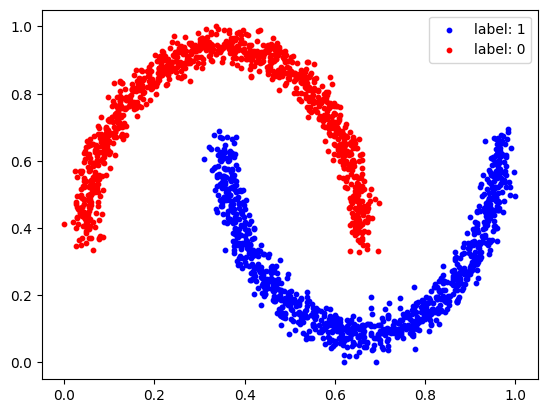

In [8]:
# Plot with labels
y_label = Y.astype(bool)
X_train, Y_train = data[..., 0], data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color="blue")
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color="red")
plt.legend(["label: 1", "label: 0"])

# Compare Models

In [9]:
results = {}

the model-based density function for $Y$ is therefore

$f_{\boldsymbol{Y}}(\boldsymbol{y})=\prod_{j=1}^{J} \phi_{0,1}\left(\lambda_{j 1} \tilde{h}_{1}\left(y_{1}\right)+\ldots+\lambda_{j, j-1} \tilde{h}_{j-1}\left(y_{j-1}\right)+\tilde{h}_{j}\left(y_{j}\right)\right) \frac{\partial \tilde{h}_{j}\left(y_{j}\right)}{\partial y_{j}}$

Summarising the model's specifications, our multivariate transformation model is characterised by a set of marginal transformations $\tilde{h}_{j}\left(y_{j}\right), j=1, \ldots, J$, each applying to only a single component of the vector $\boldsymbol{Y}$, and by a lower triangular $(J \times J)$ matrix of transformation coefficients

$\boldsymbol{\Lambda}=\left(\begin{array}{ccccc}1 & & & & 0 \\ \lambda_{21} & 1 & & & \\ \lambda_{31} & \lambda_{32} & 1 & & \\ \vdots & \vdots & & \ddots & \\ \lambda_{J 1} & \lambda_{J 2} & \ldots & \lambda_{J, J-1} & 1\end{array}\right)$

For the transformation functions $\tilde{h}_{j}$, the explicit representation
$$
\tilde{h}_{j}\left(Y_{j}\right)=\Phi_{0, \sigma_{j}^{2}}^{-1}\left(F_{j}\left(Y_{j}\right)\right)=\tilde{Z}_{j}
$$
is obtained, where $F_{j}(\cdot)$ is the univariate marginal CDF of $Y_{j}$. In summary,
$$
\begin{aligned}
\mathbb{P}(\boldsymbol{Y} \leq \boldsymbol{y}) &=\mathbb{P}(\tilde{\boldsymbol{Z}} \leq \tilde{\boldsymbol{z}})=\Phi_{0, \boldsymbol{\Sigma}}(\tilde{\boldsymbol{z}})=\Phi_{\mathbf{0}, \boldsymbol{\Sigma}}\left[\Phi_{0, \sigma_{1}^{2}}^{-1}\left\{F_{1}\left(y_{1}\right)\right\}, \ldots, \Phi_{0, \sigma_{J}^{2}}^{-1}\left\{F_{J}\left(y_{J}\right)\right\}\right] \\
&=\Phi_{0, \boldsymbol{\Sigma}}\left(\tilde{h}_{1}\left(y_{1}\right), \ldots, \tilde{h}_{J}\left(y_{J}\right)\right)
\end{aligned}
$$
and therefore the CDF of $\boldsymbol{Y}$ has exactly the same structure as a Gaussian copula, except that our representation relies on a different parameterisation of $\boldsymbol{\Sigma}$ through $\boldsymbol{\Sigma}=\Lambda^{-1} \Lambda^{-\top}$.

In [10]:
dims = 2

## Multivariate Normal

In [11]:
def get_multivariate_normal_lambda(dims):
    def lmbd(pv):
        loc = pv[..., :dims]
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., dims:])
        mv_normal = tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)
        return mv_normal

    return lmbd

In [12]:
def fit_multivariate_normal(data, dims, epochs, seed, learning_rate):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    pv_shape = dims + np.sum(np.arange(dims + 1))
    pv = tf.Variable(tf.random.normal([pv_shape], dtype=tf.float32), trainable=True)
    mn = get_multivariate_normal_lambda(dims)

    print("Number of Parameters:", tf.size(pv).numpy())

    it = trange(epochs)
    for i in it:
        # for batch in tqdm(data.reshape((-1, batch_size, 2)), leave=False):
        nll = get_nll(mn, pv, data)
        opt.minimize(nll, var_list=[pv])
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))
    return nll().numpy().mean(), mn(pv)

In [13]:
nll, multivariate_normal = fit_multivariate_normal(
    data, dims=dims, epochs=500, seed=1, learning_rate=0.1
)
results["Multivariate Normal"] = nll

Number of Parameters: 5


2023-03-31 14:58:31.733220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-31 14:58:31.733249: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-31 14:58:31.733270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arch.microos-tp): /proc/driver/nvidia/version does not exist
2023-03-31 14:58:31.733516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  0%|          | 0/500 [00:00<?, ?it/s]

sampling took 0.010492086410522461 seconds.


/tmp/ipykernel_7230/4153950975.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


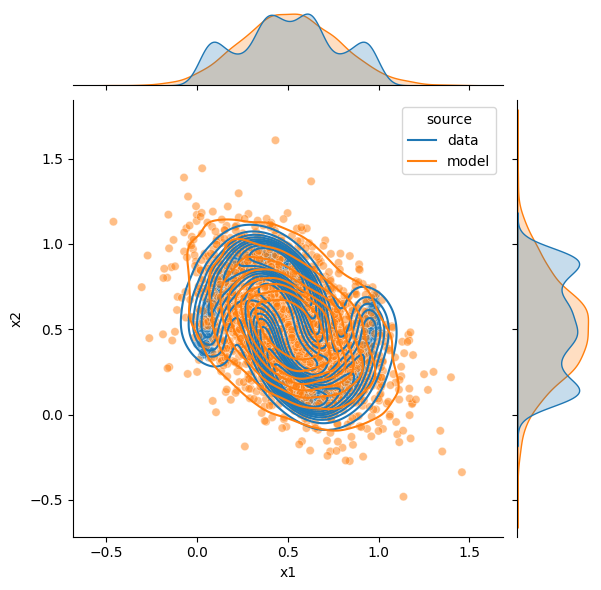

In [14]:
plot_samples(multivariate_normal, data, seed=1)

In [15]:
multivariate_normal.parameters

{'loc': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5058009 , 0.51197064], dtype=float32)>,
 'scale_tril': <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.2657475 ,  0.        ],
        [-0.12615211,  0.252557  ]], dtype=float32)>,
 'validate_args': False,
 'allow_nan_stats': True,
 'experimental_use_kahan_sum': False,
 'name': 'MultivariateNormalTriL'}

## Klein 2019: Multivariate Conditional Transformation Models

the model-based density function for $Y$ is therefore

$f_{\boldsymbol{Y}}(\boldsymbol{y})=\prod_{j=1}^{J} \phi_{0,1}\left(\lambda_{j 1} \tilde{h}_{1}\left(y_{1}\right)+\ldots+\lambda_{j, j-1} \tilde{h}_{j-1}\left(y_{j-1}\right)+\tilde{h}_{j}\left(y_{j}\right)\right) \frac{\partial \tilde{h}_{j}\left(y_{j}\right)}{\partial y_{j}}$

Summarising the model's specifications, our multivariate transformation model is characterised by a set of marginal transformations $\tilde{h}_{j}\left(y_{j}\right), j=1, \ldots, J$, each applying to only a single component of the vector $\boldsymbol{Y}$, and by a lower triangular $(J \times J)$ matrix of transformation coefficients

$\boldsymbol{\Lambda}=\left(\begin{array}{ccccc}1 & & & & 0 \\ \lambda_{21} & 1 & & & \\ \lambda_{31} & \lambda_{32} & 1 & & \\ \vdots & \vdots & & \ddots & \\ \lambda_{J 1} & \lambda_{J 2} & \ldots & \lambda_{J, J-1} & 1\end{array}\right)$

For the transformation functions $\tilde{h}_{j}$, the explicit representation
$$
\tilde{h}_{j}\left(Y_{j}\right)=\Phi_{0, \sigma_{j}^{2}}^{-1}\left(F_{j}\left(Y_{j}\right)\right)=\tilde{Z}_{j}
$$
is obtained, where $F_{j}(\cdot)$ is the univariate marginal CDF of $Y_{j}$. In summary,
$$
\begin{aligned}
\mathbb{P}(\boldsymbol{Y} \leq \boldsymbol{y}) &=\mathbb{P}(\tilde{\boldsymbol{Z}} \leq \tilde{\boldsymbol{z}})=\Phi_{0, \boldsymbol{\Sigma}}(\tilde{\boldsymbol{z}})=\Phi_{\mathbf{0}, \boldsymbol{\Sigma}}\left[\Phi_{0, \sigma_{1}^{2}}^{-1}\left\{F_{1}\left(y_{1}\right)\right\}, \ldots, \Phi_{0, \sigma_{J}^{2}}^{-1}\left\{F_{J}\left(y_{J}\right)\right\}\right] \\
&=\Phi_{0, \boldsymbol{\Sigma}}\left(\tilde{h}_{1}\left(y_{1}\right), \ldots, \tilde{h}_{J}\left(y_{J}\right)\right)
\end{aligned}
$$
and therefore the CDF of $\boldsymbol{Y}$ has exactly the same structure as a Gaussian copula, except that our representation relies on a different parameterisation of $\boldsymbol{\Sigma}$ through $\boldsymbol{\Sigma}=\Lambda^{-1} \Lambda^{-\top}$.

In [16]:
def get_mctm_lambda(dims, M, thetas_constrain_fn):
    def lmbd(pv):
        bs = prefer_static.shape(pv)[:-1]
        shape = tf.concat((bs, [dims, M]), 0)

        thetas = thetas_constrain_fn(tf.reshape(pv[..., : M * dims], shape))
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., M * dims :])

        mv_normal = tfd.MultivariateNormalTriL(loc=0, scale_tril=scale_tril)

        return tfd.TransformedDistribution(
            distribution=mv_normal,
            bijector=tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas)),
        )

    return lmbd

In [17]:
def fit_mctm(data, M, dims, epochs, seed, learning_rate, **kwds):
    set_seed(seed)

    pv_shape = M * dims + np.sum(np.arange(dims + 1))
    pv = tf.Variable(tf.random.normal([pv_shape], dtype=tf.float32), trainable=True)

    thetas_constrain_fn = get_thetas_constrain_fn(**kwds)

    mctm = get_mctm_lambda(dims, M, thetas_constrain_fn)

    print("Number of Parameters:", tf.size(pv).numpy())

    opt = tf.optimizers.Adam(learning_rate)
    it = trange(epochs)
    # idx = np.arange(n_samples)
    for i in it:
        # np.random.shuffle(idx)
        # for batch in tqdm(data[idx].reshape((-1, 100, 2)), leave=False):
        nll = get_nll(mctm, pv, data)
        opt.minimize(nll, var_list=[pv])
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), mctm(pv)

In [184]:
nll, mctm = fit_mctm(
    data,
    M=50,
    dims=dims,
    epochs=400,
    seed=1,
    learning_rate=0.1,
    low=-3,
    high=3,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    # eps=1e-04,
)
results["MCTM"] = nll

Number of Parameters: 103


  0%|          | 0/400 [00:00<?, ?it/s]

sampling took 0.1591627597808838 seconds.


/tmp/ipykernel_7230/2847470799.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


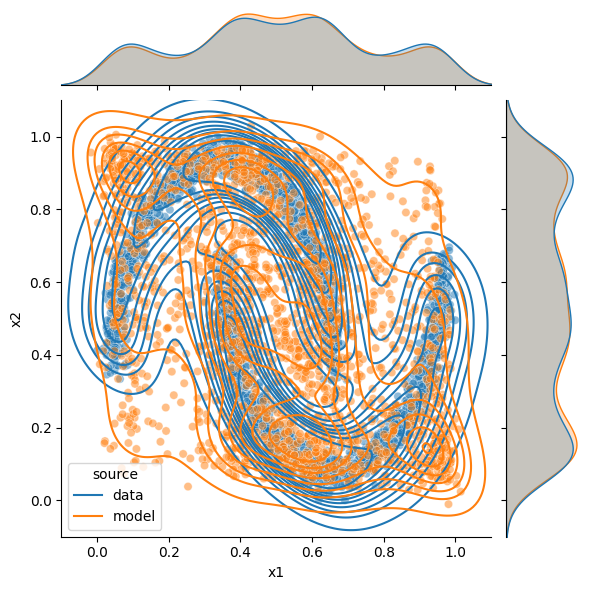

In [185]:
plot_samples(mctm, data, seed=1)

In [20]:
mctm.parameters

{'distribution': <tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>,
 'bijector': <tfp.bijectors._Invert 'invert_bernstein_bijector' batch_shape=[2] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=? bijector=<tfp.bijectors.BernsteinBijectorLinearExtrapolate 'bernstein_bijector' batch_shape=[2] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>>,
 'kwargs_split_fn': <function tensorflow_probability.python.distributions.transformed_distribution._default_kwargs_split_fn(kwargs)>,
 'validate_args': False,
 'parameters': None,
 'name': None}

## Dinh et al. 2017: Density estimation using Real NVP

Unsupervised learning of probabilistic models is a central yet challenging problem in machine learning. Specifically, designing models with tractable learning, sampling, inference and evaluation is crucial in solving this task. We extend the space of such models using real-valued non-volume preserving (real NVP) transformations, a set of powerful invertible and learnable transformations, resulting in an unsupervised learning algorithm with exact log-likelihood computation, exact sampling, exact inference of latent variables, and an interpretable latent space. We demonstrate its ability to model natural images on four datasets through sampling, log-likelihood evaluation and latent variable manipulations. 

### Affine Coupling Layers

The RealNVP (Real-valued Non-Volume Preserving) model stacks a sequence of so called affine coupling layers (ACLs).

Each ACL only operate on a part of the input:

- The first $d$ Elements ramian unchanged
- The Remaining Part is scalled and shifted

$$
\begin{aligned}
\mathbf{y}_{1:d} &= \mathbf{x}_{1:d} \\ 
\mathbf{y}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp({s(\mathbf{x}_{1:d})}) + t(\mathbf{x}_{1:d})
\end{aligned}
$$

This enshures that the Jacobean is a lower triangualr Matrix

$$
\mathbf{J} = 
\begin{bmatrix}
  \mathbb{I}_d & \mathbf{0}_{d\times(D-d)} \\[5pt]
  \frac{\partial \mathbf{y}_{d+1:D}}{\partial \mathbf{x}_{1:d}} & \text{diag}(\exp(s(\mathbf{x}_{1:d})))
\end{bmatrix}
$$

Permuation after every ACL enshures that every dimension is transformed.

In [86]:
def get_param_net(hidden_layers, params):
    network = K.Sequential(
        [K.layers.Input((dims // 2))]
        + [K.layers.Dense(d, activation="relu") for d in hidden_layers]
        + [K.layers.Dense(params)]
    )

    return network

In [85]:
def get_shift_and_log_scale_fn(hidden_layers):
    network = get_param_net(hidden_layers, 2)

    shift_and_log_scale_fn = lambda x, input_depth: tf.split(
        network(x), 2 * input_depth, axis=-1
    )
    return shift_and_log_scale_fn, network.trainable_variables

In [52]:
def fit_real_nvp(
    data,
    dims,
    epochs,
    seed,
    learning_rate,
    coupling_layers,
    hidden_units,
    activation,
    distribution,
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    trainable_variables = []
    bijectors = []
    for _ in range(coupling_layers):
        shift_and_log_scale_fn, variables = get_shift_and_log_scale_fn(hidden_units)
        trainable_variables += variables
        bijectors.append(
            tfb.RealNVP(
                num_masked=(dims // 2), shift_and_log_scale_fn=shift_and_log_scale_fn
            )
        )
        bijectors.append(tfb.Permute(permutation=[1, 0]))

    deep_nvp = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.Chain(bijectors),
    )

    print("Number of Parameters:", sum(map(tf.size, trainable_variables)).numpy())

    it = trange(epochs)
    for i in it:
        nll = lambda: -deep_nvp.log_prob(data)
        opt.minimize(nll, var_list=trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), deep_nvp

In [53]:
nll, nvp = fit_real_nvp(
    data,
    dims=dims,
    epochs=200,
    seed=1,
    learning_rate=0.005,
    hidden_units=(16, 16),
    coupling_layers=4,
    activation="relu",
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[2]),
)
results["realNVP"] = nll

Number of Parameters: 1352


  0%|          | 0/200 [00:00<?, ?it/s]

sampling took 0.042524099349975586 seconds.


/tmp/ipykernel_7230/4153950975.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


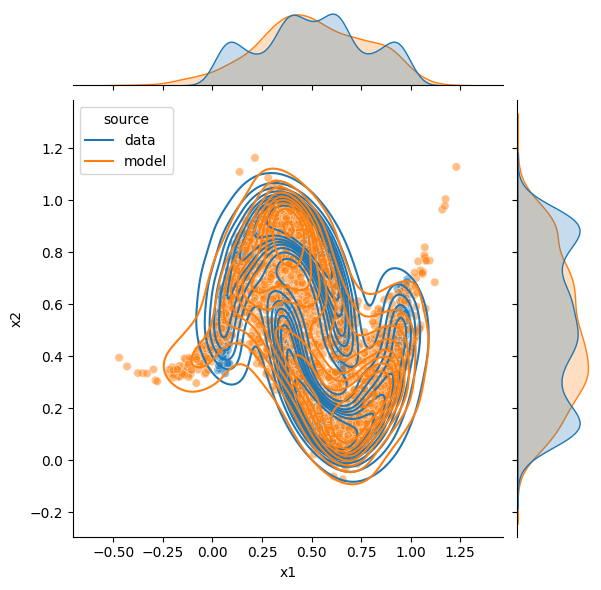

In [24]:
plot_samples(nvp, data, seed=1)

## Germain et al. 2015: MADE: Masked Autoencoderkerasr Distribution Estimation

### Abstract
Germain et al. [4] introduced a simple modification for autoencoder neural networks that masks the parameters process the inputs folowing autoregressive constraints.
Each input is reconstructed only from previous inputs in a given ordering.
This way, the autoencoder outputs can be interpreted as a set of conditional probabilities, and their product, the full joint probability.

It is alos posible to train a single network that can decompose the joint probability in multiple different orderings.

### Autoencoder

An autoencoder attempts to learn a feed-forward, hidden representation $\mathbf{h}(\mathbf{x})$ of its input $\mathbf{x}$ such that, from it, we can obtain a reconstruction $\widehat{\mathrm{x}}$ which is as close as possible to $\mathrm{x}$. Specifically, we have

$$
\begin{aligned}
\mathbf{h}(\mathbf{x}) &=\mathbf{g}(\mathbf{b}+\mathbf{W} \mathbf{x}) \\
\widehat{\mathbf{x}} &=\operatorname{sigm}(\mathbf{c}+\mathbf{V h}(\mathbf{x})),
\end{aligned}
$$

where $\mathbf{W}$ and $\mathbf{V}$ are matrices, $\mathbf{b}$ and $\mathbf{c}$ are vectors, $\mathbf{g}$ is a nonlinear activation function and $\operatorname{sigm}(a)=1 /(1+\exp (-a))$. Thus, W represents the connections from the input to the hidden layer, and V represents the connections from the hidden to the output layer.

### Distribution Estimation as Autoregression

For any distribution, the probability product rule implies that we can always decompose it into the product of its nested conditionals:

$$
p(\mathbf{x})=\prod_{d=1}^{D} p\left(x_{d} \mid \mathbf{x}<d\right)
$$

where $\mathbf{x}_{<d}=\left[x_{1}, \ldots, x_{d-1}\right]^{\top}$.

Each output $\widehat{x}_{d}=p\left(x_{d} \mid \mathbf{x}_{<d}\right)$ must be a function taking as input $\mathbf{x}_{<d}$ only and outputting the probability of observing value $x_{d}$ at the $d^{\text {th }}$ dimension.
In particular, the autoencoder forms a proper distribution if each output unit $\hat{x}_{d}$ only depends on the previous input units $\mathbf{x}_{<d}$, and not the other units $\mathbf{x}_{\geq d}=\left[x_{d}, \ldots, x_{D}\right]^{\top}$.

### Masked Autoencoders

To satisfy the autoregressive property, output $\hat{x}_{d}$ must depend only on the preceding inputs $\mathbf{x}_{<d}$.
Hence there must be no computational path between output unit $\hat{x}_{d}$ and any of the input units $x_{d}, \ldots, x_{D}$.

In other words, for each of these paths, at least one connection in the neural Network must be 0.

A convenient way of zeroing connections is to elementwisemultiply each matrix by a binary mask matrix, whose entries that are set to 0 correspond to the connections we wish to remove. For a single hidden layer autoencoder, we write

$$
\begin{aligned}
\mathbf{h}(\mathbf{x}) &=\mathbf{g}\left(\mathbf{b}+\left(\mathbf{W} \odot \mathbf{M}^{\mathbf{W}}\right) \mathbf{x}\right) \\
\hat{\mathbf{x}} &=\operatorname{sigm}\left(\mathbf{c}+\left(\mathbf{V} \odot \mathbf{M}^{\mathbf{V}}\right) \mathbf{h}(\mathbf{x})\right)
\end{aligned}
$$

where $\mathbf{M}^{\mathbf{W}}$ and $\mathbf{M}^{\mathbf{V}}$ are the masks for $\mathbf{W}$ and $\mathbf{V}$ respectively. It is thus left to the masks $\mathbf{M}^{\mathbf{W}}$ and $\mathbf{M}^{\mathbf{V}}$ to satisfy the autoregressive property.

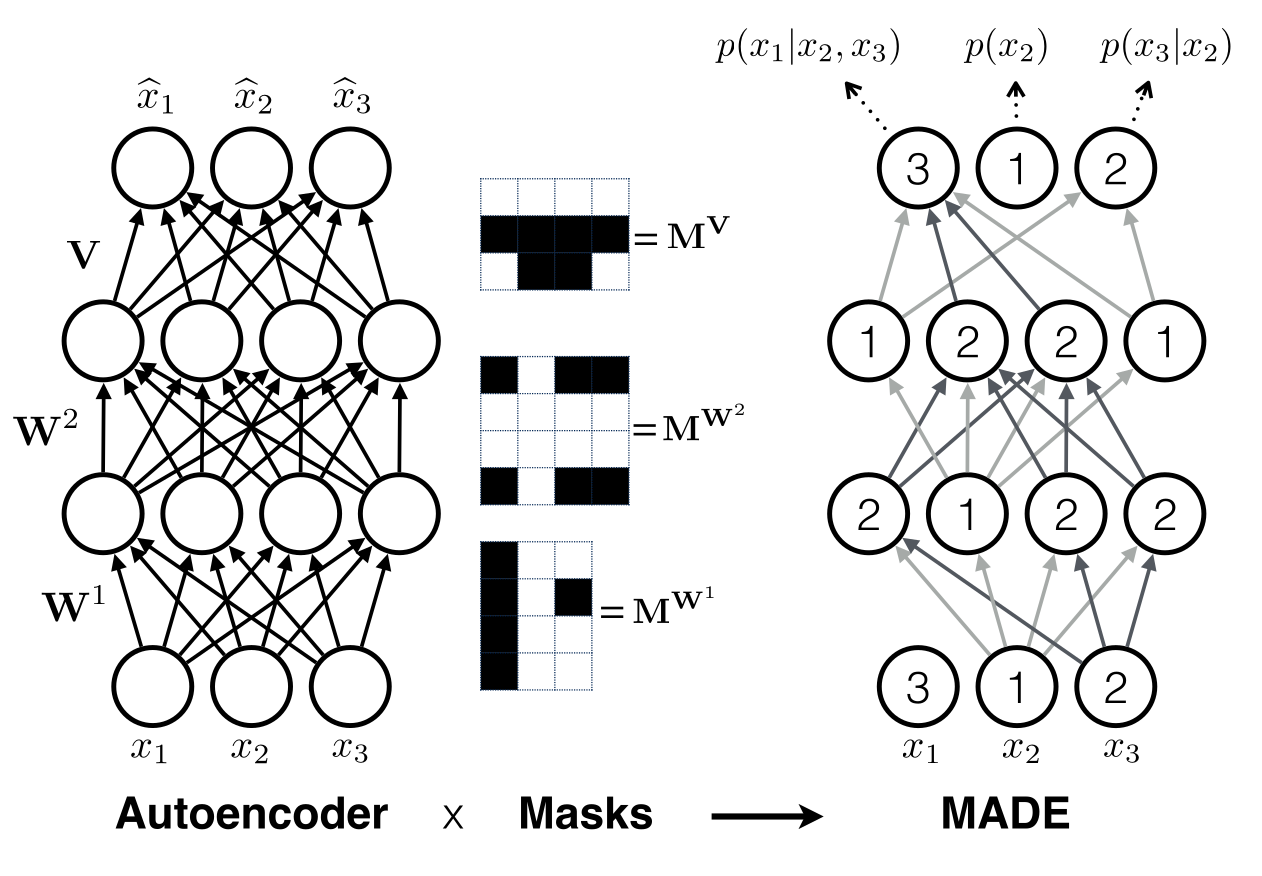

> Left: Conventional three hidden layer autoencoder.
Input in the bottom is passed through fully connected layers and
point-wise nonlinearities. In the final top layer, a reconstruction
specified as a probability distribution over inputs is produced.
As this distribution depends on the input itself, a standard au-
toencoder cannot predict or sample new data. Right: MADE.
The network has the same structure as the autoencoder, but a set
of connections is removed such that each input unit is only pre-
dicted from the previous ones, using multiplicative binary masks
($M^{W^1}$, $M^{W^1}$, $M^V$ ). In this example, the ordering of the input
is changed from 1,2,3 to 3,1,2. This change is explained in sec-
tion 4.2, but is not necessary for understanding the basic principle.
The numbers in the hidden units indicate the maximum number
of inputs on which the kth unit of layer l depends. The masks are
constructed based on these numbers (see Equations 12 and 13).
These masks ensure that MADE satisfies the autoregressive prop-
erty, allowing it to form a probabilistic model, in this example
$p(x) = p(x_2) p(x_3|x_2) p(x_1|x_2,x_3)$. Connections in light gray
correspond to paths that depend only on 1 input, while the dark
gray connections depend on 2 inputs.

### Constructing the Masks

To impose the autoregressive property we first assign each unit in the hidden layer an integer $m$ between 1 and $D-1$ inclusively. The $k^{\text {th }}$ hidden unit's number $m(k)$ gives the maximum number of input units to which it can be connected. We disallow $m(k)=D$ since this hidden unit would depend on all inputs and could not be used in modelling any of the conditionals $p\left(x_{d} \mid \mathbf{x}_{<d}\right)$. Similarly, we exclude $m(k)=0$, as it would create constant hidden units.

The constraints on the maximum number of inputs to each hidden unit are encoded in the matrix masking the connections between the input and hidden units:
$$
M_{k, d}^{\mathrm{W}}=1_{m(k) \geq d}= \begin{cases}1 & \text { if } m(k) \geq d \\ 0 & \text { otherwise }\end{cases}
$$
for $d \in\{1, \ldots, D\}$ and $k \in\{1, \ldots, K\}$. Overall, we need to encode the constraint that the $d^{\text {th }}$ output unit is only connected to $\mathbf{x}_{<d}$ (and thus not to $\mathbf{x}_{\geq d}$ ). Therefore the output weights can only connect the $d^{\text {th }}$ output to hidden units with $m(k)<d$, i.e. units that are connected to at most $d-1$ input units. These constraints are encoded in the output mask matrix:
$$
M_{d, k}^{\mathrm{V}}=1_{d>m(k)}= \begin{cases}1 & \text { if } d>m(k) \\ 0 & \text { otherwise }\end{cases}
$$
again for $d \in\{1, \ldots, D\}$ and $k \in\{1, \ldots, K\}$. **Notice that, from this rule, `no hidden units will be connected to the first output` unit $\hat{x}_{1}$, as desired.**

From these mask constructions, we can easily demonstrate that the corresponding masked autoencoder satisfies the autoregressive property. First, we note that, since the masks $\mathbf{M}^{\mathbf{V}}$ and $\mathbf{M}^{\mathbf{W}}$ represent the network's connectivity, their matrix product $\mathbf{M}^{\mathbf{V}, \mathbf{W}}=\mathbf{M}^{\mathbf{V}} \mathbf{M}^{\mathbf{W}}$ represents the connectivity between the input and the output layer.

Constructing the masks $M^{V}$ and $M^{W}$ only requires an
assignment of the $m(k)$ values to each hidden unit. One could imagine trying to
assign an (approximately) equal number of units to each legal value of $m(k)$.
In our experiments, we instead set $m(k)$ by sampling from a uniform discrete
distribution defined
on integers from $1$ to $D-1$, independently for each of the $K$ hidden units.

### TFP implementation of Made Network

[`tfb.masked_autoregressive`](https://github.com/tensorflow/probability/blob/e3d67c00ab491f4314a3d3e8c2cde19c8aa7490e/tensorflow_probability/python/bijectors/masked_autoregressive.py) contains a TF implemetations of MADE Network

its uses the function [`_make_dense_autoregressive_mask`](https://github.com/tensorflow/probability/blob/e3d67c00ab491f4314a3d3e8c2cde19c8aa7490e/tensorflow_probability/python/bijectors/masked_autoregressive.py#L1148) to generate the Masks.

In [54]:
def fit_made(
    data, dims, epochs, seed, learning_rate, hidden_units, activation, distribution
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    made_net = tfb.AutoregressiveNetwork(
        params=dims,  # number of prammeters (output) per input dim
        hidden_units=hidden_units,
        # event_shape=(dims,),
        activation=activation,
    )
    made_net.build((dims,))

    made_distribution = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.MaskedAutoregressiveFlow(made_net),
    )

    print(
        "Number of Parameters:", sum(map(tf.size, made_net.trainable_variables)).numpy()
    )

    it = trange(epochs)
    for i in it:
        nll = lambda: -made_distribution.log_prob(data)
        opt.minimize(nll, var_list=made_net.trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), made_distribution

In [55]:
nll, made = fit_made(
    data,
    dims=dims,
    epochs=1000,
    seed=1,
    learning_rate=0.01,
    hidden_units=[16, 16],
    activation="relu",
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[2]),
)
results["MADE"] = nll

Number of Parameters: 388


  0%|          | 0/1000 [00:00<?, ?it/s]

sampling took 0.018215179443359375 seconds.


/tmp/ipykernel_7230/4153950975.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


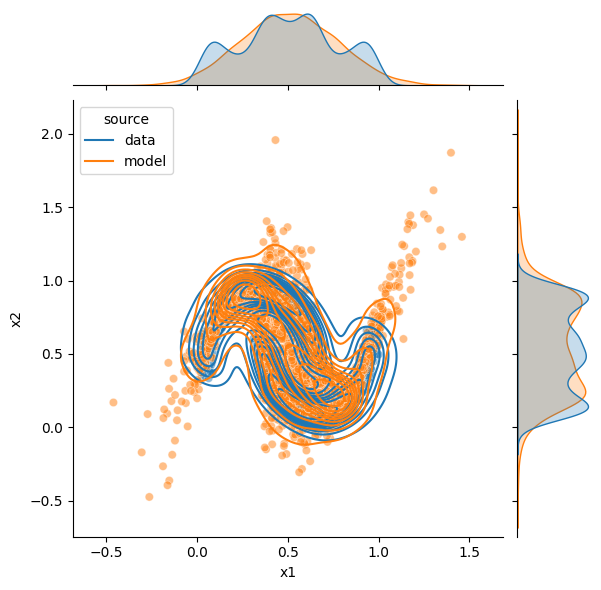

In [56]:
plot_samples(made, data, seed=1)

## G. Papamakarios 2018: Masked Autoregressive Flow for Density Estimation

Autoregressive models are among the best performing neural density estimators. We describe an approach for increasing the flexibility of an autoregressive model, based on modelling the random numbers that the model uses internally when generating data. By constructing a stack of autoregressive models, each modelling the random numbers of the next model in the stack, we obtain a type of normalizing flow suitable for density estimation, which we call Masked Autoregressive Flow. This type of flow is closely related to Inverse Autoregressive Flow and is a generalization of Real NVP. Masked Autoregressive Flow achieves state-of-the-art performance in a range of general-purpose density estimation tasks.

In [60]:
def fit_maf(
    data, dims, epochs, seed, learning_rate, hidden_units, layers, distribution
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    bijectors = []
    trainable_variables = []
    for _ in range(layers):
        made = tfb.AutoregressiveNetwork(
            params=dims, hidden_units=hidden_units, activation="relu"
        )
        made.build((dims,))
        trainable_variables += made.trainable_variables

        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))
        bijectors.append(tfb.Permute(permutation=[1, 0]))

    maf = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.Chain(bijectors),
    )

    print("Number of Parameters:", sum(map(tf.size, trainable_variables)).numpy())
    it = trange(epochs)
    for i in it:
        nll = lambda: -maf.log_prob(data)
        opt.minimize(nll, var_list=trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), maf

In [61]:
nll, maf = fit_maf(
    data,
    dims=dims,
    epochs=400,
    seed=1,
    learning_rate=0.005,
    hidden_units=[16, 16],
    layers=4,
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[2]),
)
results["MAF"] = nll

Number of Parameters: 1552


  0%|          | 0/400 [00:00<?, ?it/s]

sampling took 0.06859397888183594 seconds.


/tmp/ipykernel_7230/4153950975.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


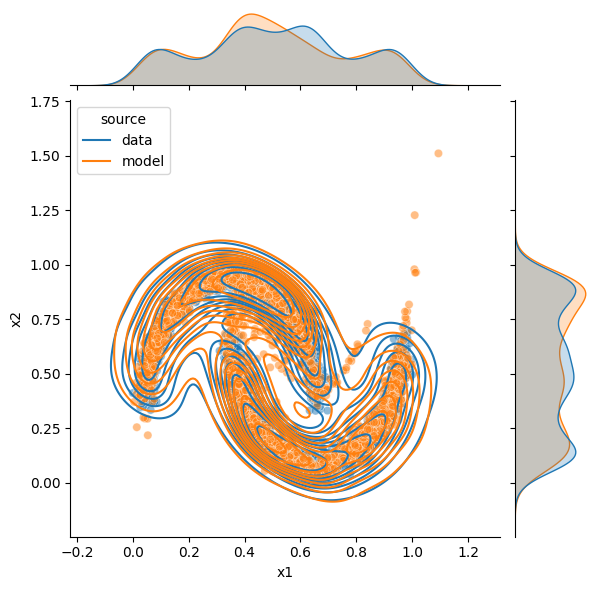

In [62]:
plot_samples(maf, data, seed=1)

## Kingma et al 2017: Improving Variational Inference with Inverse Autoregressive Flow

The framework of normalizing flows provides a general strategy for flexible vari-
ational inference of posteriors over latent variables. We propose a new type of
normalizing flow, inverse autoregressive flow (IAF), that, in contrast to earlier
published flows, scales well to high-dimensional latent spaces. The proposed flow
consists of a chain of invertible transformations, where each transformation is
based on an autoregressive neural network. In experiments, we show that IAF
significantly improves upon diagonal Gaussian approximate posteriors. In addition,
we demonstrate that a novel type of variational autoencoder, coupldistributionwith IAF, is
competitive with neural autoregressive models in terms of attained log-likelihood
on natural images, while allowing significantly faster synthesis.

By stacking multiple bijectors we increase expressivenes

In [57]:
def fit_iaf(
    data, dims, epochs, seed, learning_rate, hidden_units, layers, distribution
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    bijectors = []
    trainable_variables = []
    for _ in range(layers):
        made = tfb.AutoregressiveNetwork(
            params=dims, hidden_units=hidden_units, activation="relu"
        )
        made.build((dims,))
        trainable_variables += made.trainable_variables

        bijectors.append(
            tfb.Invert(  # Invert MAF
                tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)
            )
        )
        bijectors.append(tfb.Permute(permutation=[1, 0]))

    maf = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.Chain(bijectors),
    )

    print("Number of Parameters:", sum(map(tf.size, trainable_variables)).numpy())
    it = trange(epochs)
    for i in it:
        nll = lambda: -maf.log_prob(data)
        opt.minimize(nll, var_list=trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), maf

In [58]:
nll, iaf = fit_iaf(
    data,
    dims=dims,
    epochs=400,
    seed=1,
    learning_rate=0.005,
    hidden_units=[16, 16],
    layers=4,
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[2]),
)
results["IAF"] = nll

Number of Parameters: 1552


  0%|          | 0/400 [00:00<?, ?it/s]

sampling took 0.04031491279602051 seconds.


/tmp/ipykernel_7230/4153950975.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


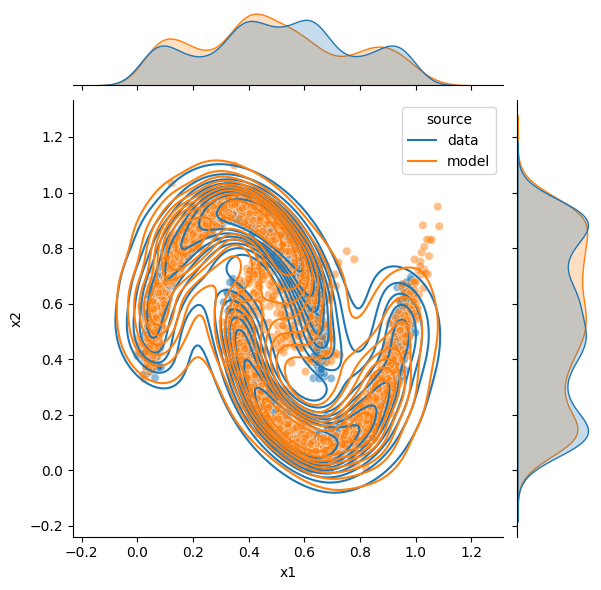

In [59]:
plot_samples(iaf, data, seed=1)

## MADE + BNF
https://github.com/tensorchiefs/bfvi/blob/main/R/multidimensional_script.R

In [96]:
def get_bijector_fn(network, thetas_constrain_fn, **kwds):
    def bijector_fn(x, **kwds):
        with tf.name_scope("bnf_made_bjector"):
            pvector = network(x, **kwds)
            thetas = thetas_constrain_fn(pvector)

            return tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas))

    return bijector_fn

In [134]:
def fit_made_mctm(
    data,
    M,
    dims,
    epochs,
    seed,
    learning_rate,
    hidden_units,
    activation,
    distribution,
    **kwds
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    made_net = tfb.AutoregressiveNetwork(
        params=M,
        hidden_units=hidden_units,
        event_shape=(dims,),
        activation=activation,
    )
    made_net.build((dims,))

    thetas_constrain_fn = get_thetas_constrain_fn(**kwds)

    bijector_fn = get_bijector_fn(
        network=made_net, thetas_constrain_fn=thetas_constrain_fn
    )

    bnf = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.MaskedAutoregressiveFlow(bijector_fn=bijector_fn),
    )

    print(
        "Number of Parameters:", sum(map(tf.size, made_net.trainable_variables)).numpy()
    )

    it = trange(epochs)
    for i in it:
        nll = lambda: -bnf.log_prob(data)
        opt.minimize(nll, var_list=made_net.trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), bnf

In [135]:
nll, made_mctm = fit_made_mctm(
    data,
    dims=dims,
    epochs=500,
    seed=1,
    learning_rate=0.05,
    hidden_units=[16, 16],
    activation="relu",
    M=50,
    low=-3,
    high=3,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    # eps=1e-04,
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[2]),
)
results["MADE + MCTM"] = nll

Number of Parameters: 2020


  0%|          | 0/500 [00:00<?, ?it/s]

TypeError: bijector_fn() missing 1 required positional argument: 'input_depth'

In [ ]:
plot_samples(made_mctm, data, seed=3)

## realNVP + BNF

In [136]:
def get_bijector_fn(network, thetas_constrain_fn, **kwds):
    def bijector_fn(x0, input_depth, **kwds):
        with tf.name_scope("bernstein_bjector"):
            pvector = network(x0)
            M = pvector.shape[-1]
            pvector = tf.reshape(pvector, (-1, input_depth, M))
            thetas = thetas_constrain_fn(pvector)

            return tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas))

    return bijector_fn

In [194]:
def fit_real_nvp_mctm(
    data,
    dims,
    epochs,
    seed,
    learning_rate,
    coupling_layers,
    hidden_units,
    activation,
    distribution,
    M,
    **kwds
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    thetas_constrain_fn = get_thetas_constrain_fn(**kwds)

    trainable_variables = []
    bijectors = []
    for l in range(coupling_layers):
        network = get_param_net(hidden_units, M)
        trainable_variables += network.trainable_variables
        bijectors.append(
            tfb.RealNVP(
                num_masked=(dims // 2),
                bijector_fn=get_bijector_fn(network, thetas_constrain_fn),
            )
        )
        if coupling_layers % 2 != 0 and l == (coupling_layers - 1):
            print("uneven number of coupling layers -> skipping last permuataion")
        else:
            bijectors.append(tfb.Permute(permutation=[1, 0]))

    nvp = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.Chain(bijectors),
    )

    print("Number of Parameters:", sum(map(tf.size, trainable_variables)).numpy())

    it = trange(epochs)
    for i in it:
        nll = lambda: -nvp.log_prob(data)
        opt.minimize(nll, var_list=trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), nvp

In [140]:
nll, real_nvp_mctm = fit_real_nvp_mctm(
    data,
    dims=dims,
    epochs=500,
    seed=1,
    learning_rate=0.01,
    coupling_layers=2,
    hidden_units=[16, 16],
    activation="relu",
    M=50,
    low=-3,
    high=3,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    # eps=1e-04,
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[2]),
)
results["realNVP + MCTM"] = nll

Number of Parameters: 2308


  0%|          | 0/500 [00:00<?, ?it/s]

sampling took 0.23530936241149902 seconds.


/tmp/ipykernel_7230/4153950975.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


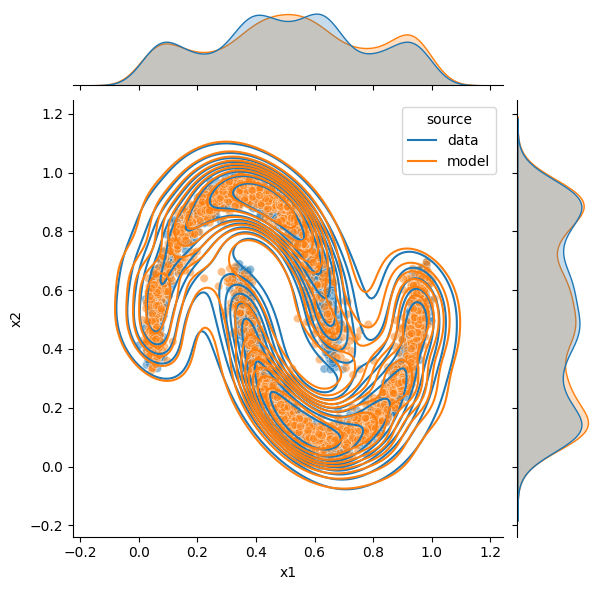

In [141]:
plot_samples(real_nvp_mctm, data, seed=3)

## MCTM as Base + ACL

In [195]:
nll, real_nvp_mctm2 = fit_real_nvp_mctm(
    data,
    dims=dims,
    epochs=1000,
    seed=1,
    learning_rate=0.01,
#    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
#  initial_learning_rate=.1, decay_steps=1000, decay_rate=.1),
    coupling_layers=1,
    hidden_units=[32, 32, 32],
    activation="relu",
    M=50,
    low=0,
    high=1,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    # eps=1e-04,
    distribution=mctm,
)
results["MCTM base + MVP"] = nll

uneven number of coupling layers -> skipping last permuataion
Number of Parameters: 3826


  0%|          | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
plot_samples(real_nvp_mctm2, data, seed=1)

## MCTM as Base + MAF

In [189]:
M = 50

epochs = 500
seed = 1
learning_rate = 0.1

set_seed(seed)

opt = tf.optimizers.Adam(learning_rate)

made2 = tfb.AutoregressiveNetwork(
    params=M,
    hidden_units=[16, 16],
    event_shape=(dims,),
    activation="relu",
)

thetas_constrain_fn = get_thetas_constrain_fn(
    low=-4,
    high=4,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    # eps=,
)

bijector_fn = get_bijector_fn(made=made2, thetas_constrain_fn=thetas_constrain_fn)

bnf2 = tfd.TransformedDistribution(
    distribution=mctm(pv),
    bijector=tfb.MaskedAutoregressiveFlow(bijector_fn=bijector_fn),
)

it = trange(epochs)
for i in it:
    nll = lambda: -bnf2.log_prob(data)
    opt.minimize(nll, var_list=made2.trainable_variables)
    it.set_postfix(loss=nll().numpy().mean(), lr=opt.learning_rate.numpy())
results["MCTM base + ACL"] = nll().numpy().mean()

TypeError: get_bijector_fn() missing 1 required positional argument: 'network'

# Results

In [ ]:
df = pd.DataFrame.from_dict(results, orient="index")
df.columns = ["NLL"]
df